# Sentiment for bot datasets

Generate sentiment predictions for the two bot datasets and analyse them.

## Initialization

Import needed packages, initialize model parameters and configure folder and file paths.

### Imports

Import necessary python packages and set 

In [1]:
import os
import pandas as pd

from keras import preprocessing, models
from matplotlib import pyplot as plt

Using TensorFlow backend.


### Parameters initialization

Initialize model parameters, files and folder used by the model.

#### Model parameters

Initialize model related parameters and folders.

In [2]:
# model information
model_name = 'CNN-LSTM'
model_version = 'final'
train_data_version = '0.2'

# model parameters
max_words = 50

# models folder
models_folder = '../models'

# dataset file locations
social_honeypot_train_csv = '../../data/interim/social_honeypot_train_clean.csv'
social_honeypot_test_csv = '../../data/interim/social_honeypot_test_clean.csv'
fake_project_train_csv = '../../data/interim/fake_project_train_clean.csv'
fake_project_test_csv = '../../data/interim/fake_project_test_clean.csv'

#output datasets with sentiment location
social_honeypot_train_sentiment_csv = '../../data/interim/bot_sentiment/social_honeypot_train_sentiment.csv'
social_honeypot_test_sentiment_csv = '../../data/interim/bot_sentiment/social_honeypot_test_sentiment.csv'
fake_project_train_sentiment_csv = '../../data/interim/bot_sentiment/fake_project_train_sentiment.csv'
fake_project_test_sentiment_csv = '../../data/interim/bot_sentiment/fake_project_test_sentiment.csv'

#### File and folder names

Initialize file and folder names.


In [3]:
# model folder and model file
model_folder = os.path.join(models_folder, model_name)
model_file = os.path.join(model_folder,
                          model_name + '_' + model_version + '.h5')

tokenizer_file = os.path.join(model_folder,
                              'tokenizer_' + train_data_version + '.pickle')


## Calculate sentiment

Load social bot datasets form disk and generate sentiment probabilites for them, then save them back to disk.

#### Load datasets from disk

Load datasets from disk

In [ ]:
df_shp_train = pd.read_csv(social_honeypot_train_csv)
df_shp_test = pd.read_csv(social_honeypot_test_csv)
df_fp_train = pd.read_csv(fake_project_train_csv)
df_fp_test = pd.read_csv(fake_project_test_csv)

df_shp_train.text = df_shp_train.text.astype(str)
df_shp_test.text = df_shp_test.text.astype(str)
df_fp_train.text = df_fp_train.text.astype(str)
df_fp_test.text = df_fp_test.text.astype(str)

#### Load model from disk

Load the model from disk

In [5]:
model = models.load_model(model_file)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         12800000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 200)         256200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 200)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 200)         200200    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 200)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
______________________

#### Load tokenizer from disk

Load the prefitted tokenizer form disk

In [6]:
with open(tokenizer_file, 'rb') as file:
    tokenizer = pickle.load(file)

#### Create word vectors from datasets

Create word vectors

In [7]:
shp_train_tokenized_text = tokenizer.texts_to_sequences(df_shp_train.text)
shp_train_data = preprocessing.sequence.pad_sequences(shp_train_tokenized_text, maxlen=max_words)

shp_test_tokenized_text = tokenizer.texts_to_sequences(df_shp_test.text)
shp_test_data = preprocessing.sequence.pad_sequences(shp_test_tokenized_text, maxlen=max_words)

In [8]:
fp_train_tokenized_text = tokenizer.texts_to_sequences(df_fp_train.text)
fp_train_data = preprocessing.sequence.pad_sequences(fp_train_tokenized_text, maxlen=max_words)

fp_test_tokenized_text = tokenizer.texts_to_sequences(df_fp_test.text)
fp_test_data = preprocessing.sequence.pad_sequences(fp_test_tokenized_text, maxlen=max_words)

#### Generate predictions

Calculate predictions for both bot datasets and add them as a new column.

In [12]:
df_shp_train['sentiment'] =  model.predict(shp_train_data, verbose=1)

5176400/5176400 [==============================] - 1485s 287us/step


In [13]:
df_shp_test['sentiment'] =  model.predict(shp_test_data, verbose=1)

37694/37694 [==============================] - 11s 292us/step


In [14]:
df_fp_train['sentiment'] =  model.predict(fp_train_data, verbose=1)

6167994/6167994 [==============================] - 1783s 289us/step


In [15]:
df_fp_test['sentiment'] =  model.predict(fp_test_data, verbose=1)

39379/39379 [==============================] - 11s 288us/step


#### Save datasets

Save datasets with sentiment to disk.

In [18]:
df_shp_train.to_csv(social_honeypot_train_sentiment_csv, index=False)
df_shp_test.to_csv(social_honeypot_test_sentiment_csv, index=False)
df_fp_train.to_csv(fake_project_train_sentiment_csv, index=False)
df_fp_test.to_csv(fake_project_test_sentiment_csv , index=False)

## Analysis

Analysis of the social bot datasets.

### Load datasets

Load all datasets containing the sentiment scores from disk and combine the training and test sets.

In [4]:
df_shp_train = pd.read_csv(social_honeypot_train_sentiment_csv)
df_shp_test = pd.read_csv(social_honeypot_test_sentiment_csv)
df_fp_train = pd.read_csv(fake_project_train_sentiment_csv)
df_fp_test = pd.read_csv(fake_project_test_sentiment_csv)

df_social_honeypot = df_shp_train.append(df_shp_test)
df_fake_project = df_fp_train.append(df_fp_test)

#inline plots
%matplotlib inline
#set dpi of pyplot plots to match retina display
plt.rcParams["figure.dpi"] = 220

### Social honeypot dataset analysis

Analyse the sentiment predictions of the social honeypot dataset.

#### Create sentiment dataframe

Create a new pandas dataframe containing only the sentiment probabilities.

In [5]:
df_shp_humans = df_social_honeypot[df_social_honeypot.type==0].reset_index()
df_shp_bots = df_social_honeypot[df_social_honeypot.type==1].reset_index()
df_shp_sentiment = pd.concat([df_shp_humans.sentiment, 
                              df_shp_bots.sentiment], axis=1)
df_shp_sentiment.columns = ['humans','bots']

#### Plot histograms

Plot the sentiment probability distribution between humans and bots.

##### Histogram

Probability distribution histogram.

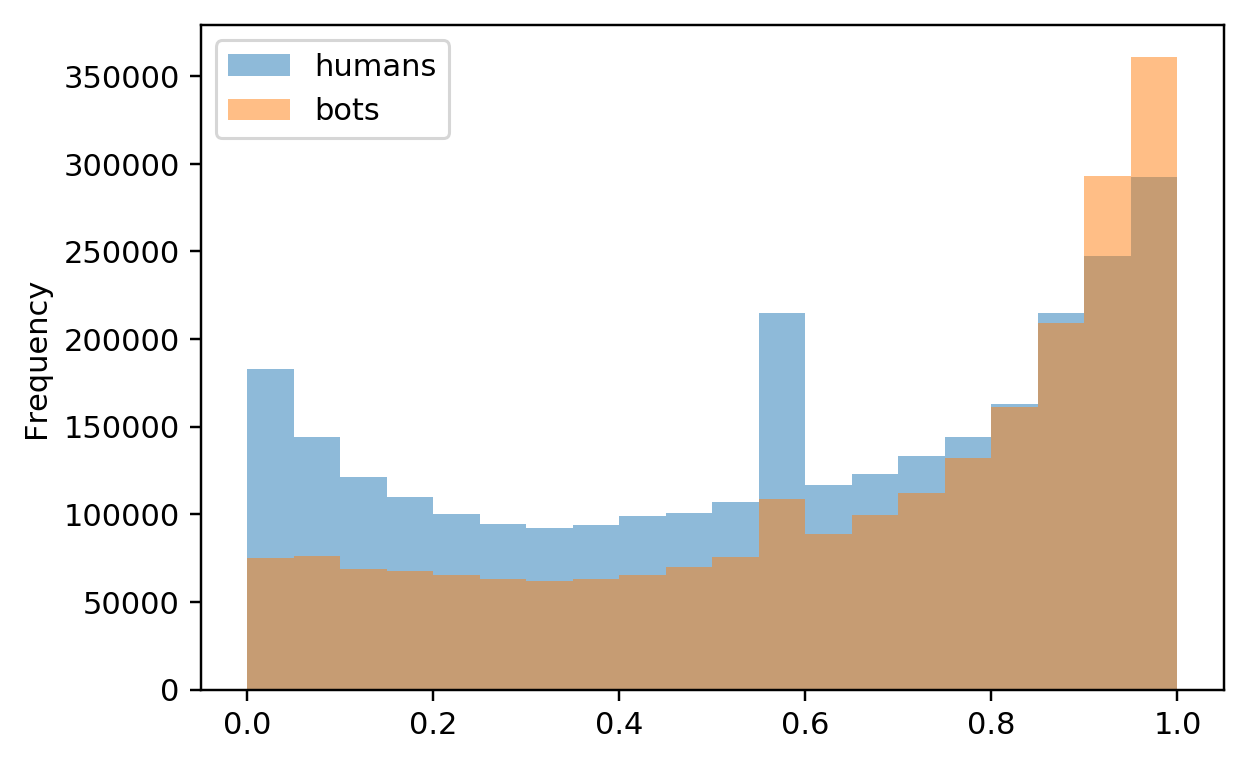

In [6]:
df_shp_sentiment.plot.hist(alpha=0.5, bins=20)

##### Normalized Histogram

Normalized probability distribution histogram.

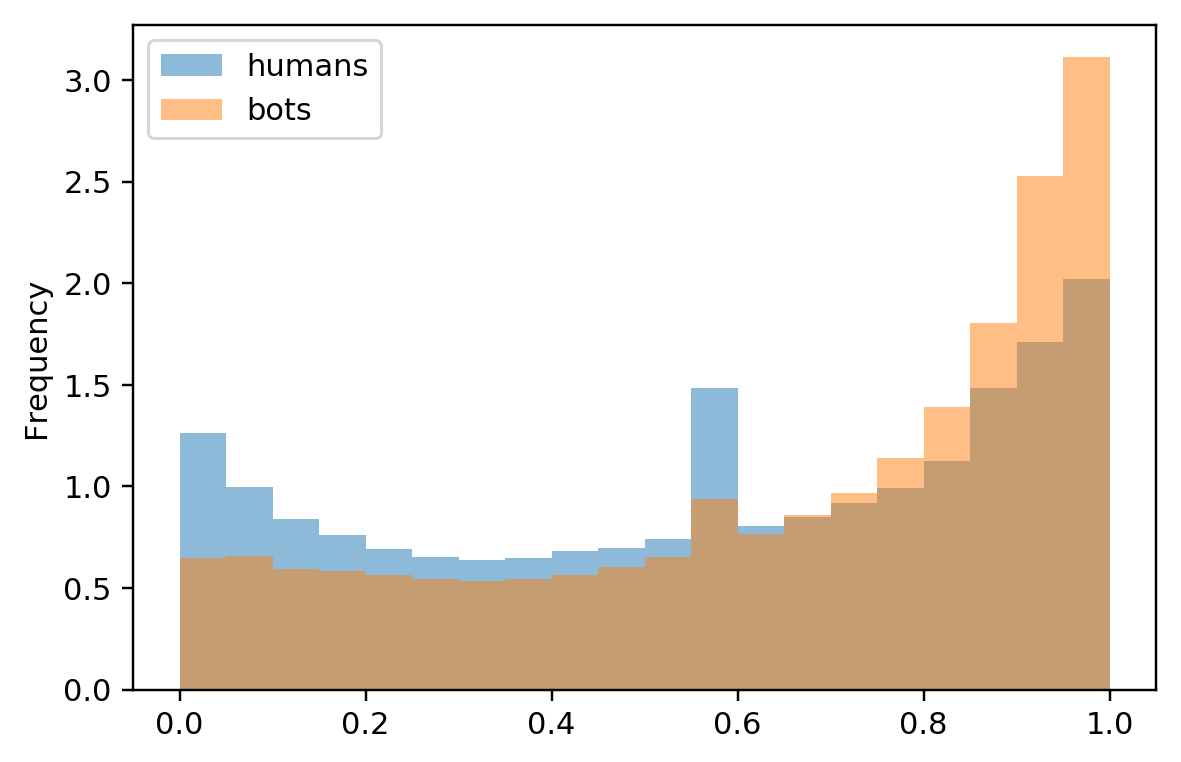

In [7]:
df_shp_sentiment.plot.hist(alpha=0.5, bins=20, density=True)

#### Plot positive and negative message count

Count the count of positive and negative messages for humans and bots.

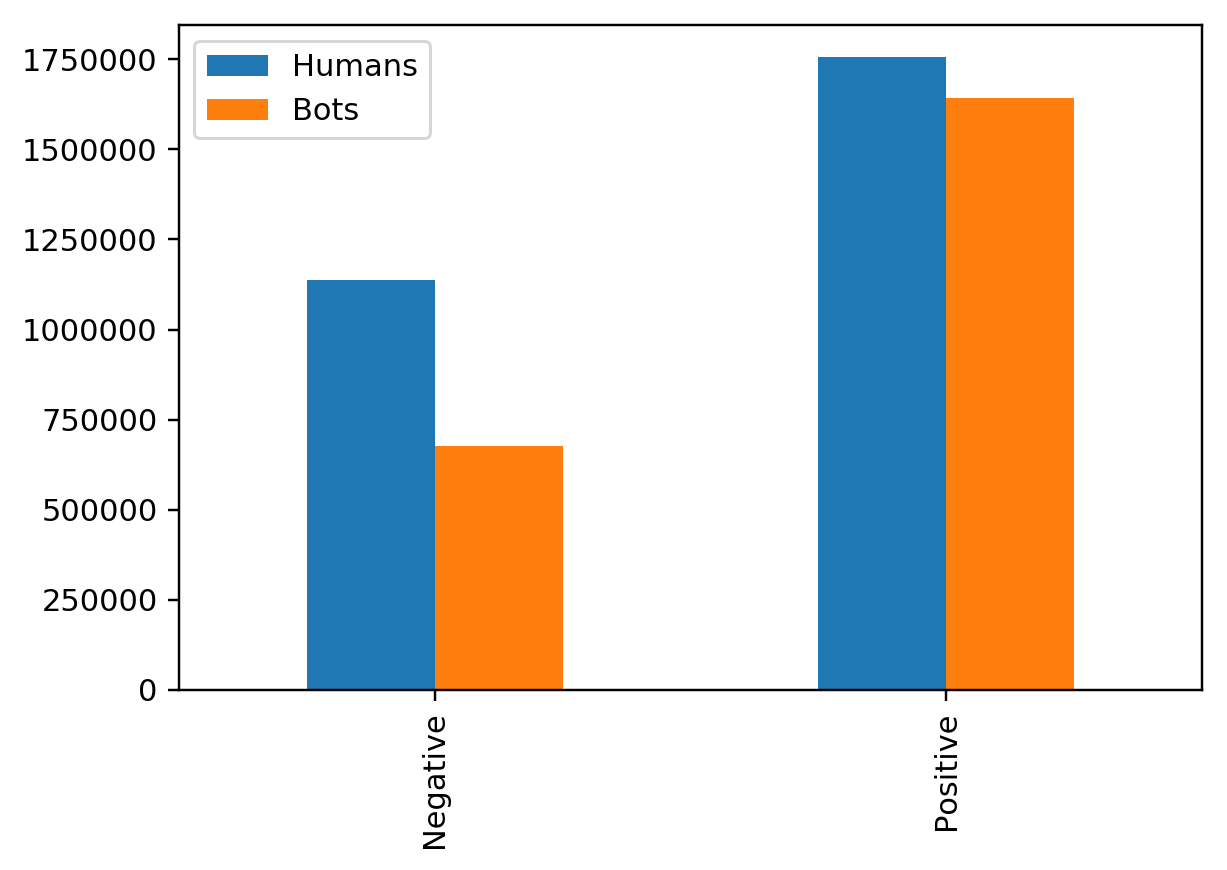

In [8]:
shp_humans_neg = len(df_shp_sentiment[df_shp_sentiment.humans < 0.5])
shp_humans_pos = len(df_shp_sentiment[df_shp_sentiment.humans > 0.5])
shp_bots_neg = len(df_shp_sentiment[df_shp_sentiment.bots < 0.5])
shp_bots_pos = len(df_shp_sentiment[df_shp_sentiment.bots > 0.5])

df_shp_count = pd.DataFrame({'Humans': {'Positive': shp_humans_pos, 'Negative': shp_humans_neg}, 
                   'Bots': {'Positive': shp_bots_pos, 'Negative': shp_bots_neg}})


df_shp_count.plot.bar()

#### Message counts, ratios and percentages

Number of total messages by humans and bots and number of positive and negative ones and their ratios.

In [9]:
shp_total_humans = len(df_shp_sentiment.humans.dropna())
shp_total_bots = len(df_shp_sentiment.bots.dropna())
print('Total by humans: ' + str(shp_total_humans))
print('Total by bots: ' + str(shp_total_bots))
print()
print('Total positive by humans: ' + str(shp_humans_pos))
print('Total negative by humans: ' + str(shp_humans_neg))
print('Percent positive by humans: ' + '{:.2%}'.format(shp_humans_pos / shp_total_humans))
print('Percent negative by humans: ' + '{:.2%}'.format(shp_humans_neg / shp_total_humans))
print('Positive ratio humans: ' + '{:.3}'.format(shp_humans_pos / shp_humans_neg))
print()
print('Total positive by bots: ' + str(shp_bots_pos))
print('Total negative by bots: ' + str(shp_bots_neg))
print('Percent positive by bots: ' + '{:.2%}'.format(shp_bots_pos / shp_total_bots))
print('Percent negative by bots: ' + '{:.2%}'.format(shp_bots_neg / shp_total_bots))
print('Positive ratio bots: ' + '{:.3}'.format(shp_bots_pos / shp_bots_neg))

Total by humans: 2894913
Total by bots: 2319181

Total positive by humans: 1756091
Total negative by humans: 1138822
Percent positive by humans: 60.66%
Percent negative by humans: 39.34%
Positive ratio humans: 1.54

Total positive by bots: 1642389
Total negative by bots: 676792
Percent positive by bots: 70.82%
Percent negative by bots: 29.18%
Positive ratio bots: 2.43


### Fake project dataset analysis

Analyse the sentiment predictions of the fake project dataset.

#### Create sentiment dataframe

Create a new pandas dataframe containing only the sentiment probabilities.

In [10]:
df_fp_humans = df_fake_project[df_fake_project.type==0].reset_index()
df_fp_bots = df_fake_project[df_fake_project.type==1].reset_index()
df_fp_sentiment = pd.concat([df_fp_humans.sentiment, 
                              df_fp_bots.sentiment], axis=1)
df_fp_sentiment.columns = ['humans','bots']

#### Plot histograms

Plot the sentiment probability distribution between humans and bots.

##### Histogram

Probability distribution histogram.

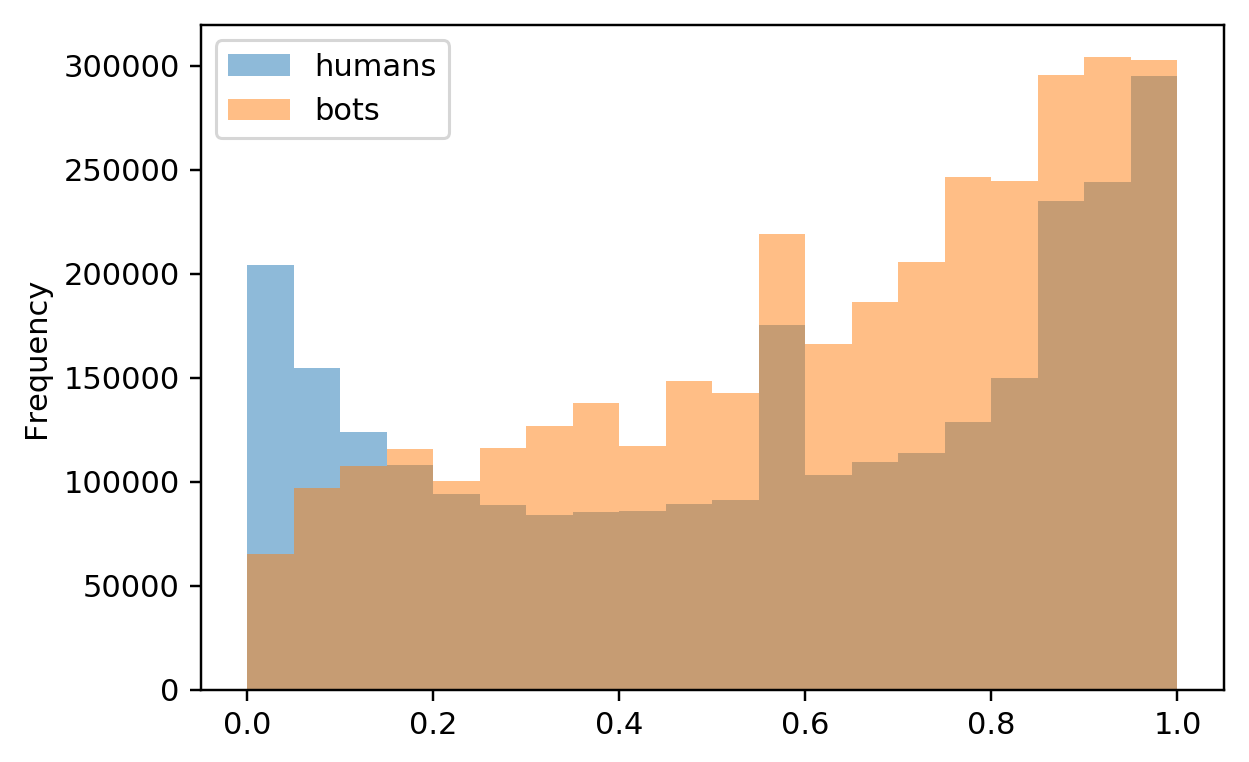

In [11]:
df_fp_sentiment.plot.hist(alpha=0.5, bins=20)

##### Normalized Histogram

Normalized probability distribution histogram.

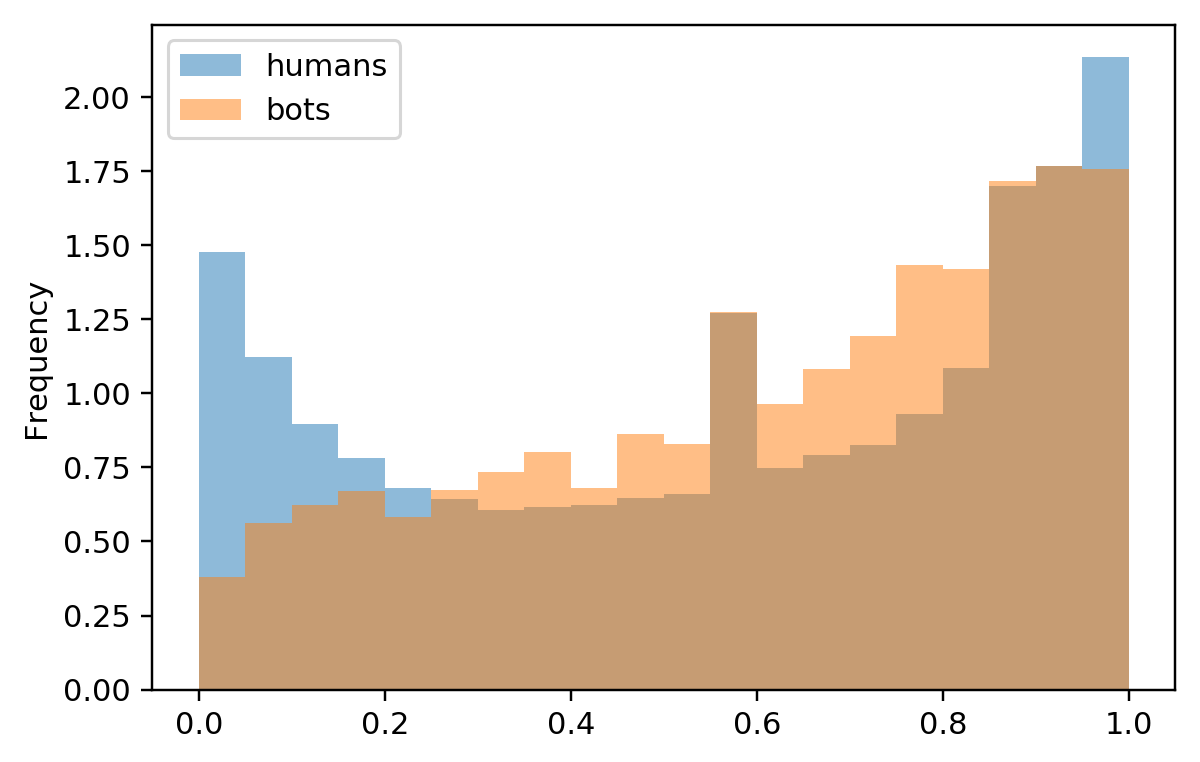

In [12]:
df_fp_sentiment.plot.hist(alpha=0.5, bins=20, density=True)

#### Plot positive and negative message count

Count the count of positive and negative messages for humans and bots.

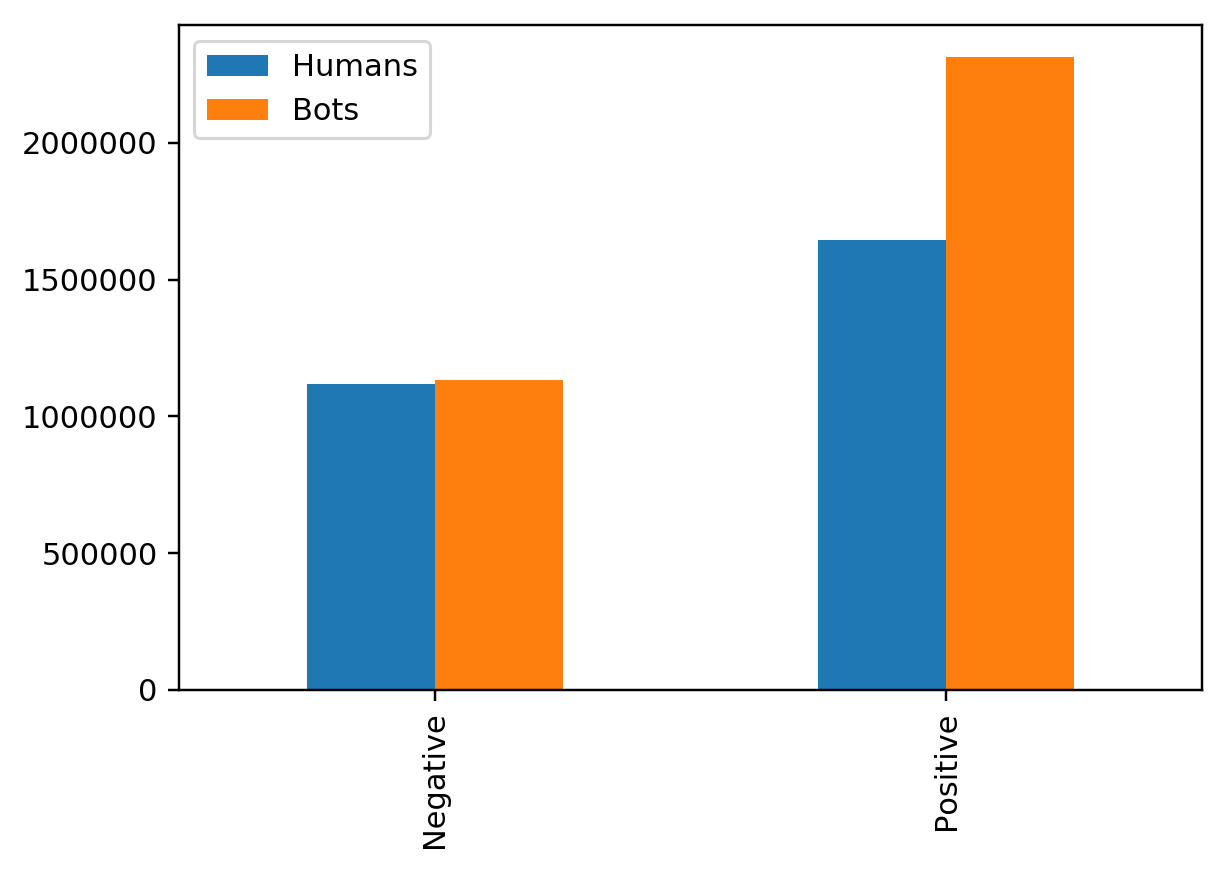

In [20]:
fp_humans_neg = len(df_fp_sentiment[df_fp_sentiment.humans < 0.5])
fp_humans_pos = len(df_fp_sentiment[df_fp_sentiment.humans > 0.5])
fp_bots_neg = len(df_fp_sentiment[df_fp_sentiment.bots < 0.5])
fp_bots_pos = len(df_fp_sentiment[df_fp_sentiment.bots > 0.5])

df_fp_count = pd.DataFrame({'Humans': {'Positive': fp_humans_pos, 'Negative': fp_humans_neg}, 
                   'Bots': {'Positive': fp_bots_pos, 'Negative': fp_bots_neg}})


df_fp_count.plot.bar()

#### Message counts, ratios and percentages

Number of total messages by humans and bots and number of positive and negative ones and their ratios.

In [14]:
fp_total_humans = len(df_fp_sentiment.humans.dropna())
fp_total_bots = len(df_fp_sentiment.bots.dropna())
print('Total by humans: ' + str(fp_total_humans))
print('Total by bots: ' + str(fp_total_bots))
print()
print('Total positive by humans: ' + str(fp_humans_pos))
print('Total negative by humans: ' + str(fp_humans_neg))
print('Percent positive by humans: ' + '{:.2%}'.format(fp_humans_pos / fp_total_humans))
print('Percent negative by humans: ' + '{:.2%}'.format(fp_humans_neg / fp_total_humans))
print('Positive ratio humans: ' + '{:.3}'.format(fp_humans_pos / fp_humans_neg))
print()
print('Total positive by bots: ' + str(fp_bots_pos))
print('Total negative by bots: ' + str(fp_bots_neg))
print('Percent positive by bots: ' + '{:.2%}'.format(fp_bots_pos / fp_total_bots))
print('Percent negative by bots: ' + '{:.2%}'.format(fp_bots_neg / fp_total_bots))
print('Positive ratio bots: ' + '{:.3}'.format(fp_bots_pos / fp_bots_neg))

Total by humans: 2762758
Total by bots: 3444615

Total positive by humans: 1644808
Total negative by humans: 1117950
Percent positive by humans: 59.54%
Percent negative by humans: 40.46%
Positive ratio humans: 1.47

Total positive by bots: 2313256
Total negative by bots: 1131359
Percent positive by bots: 67.16%
Percent negative by bots: 32.84%
Positive ratio bots: 2.04


### Combined dataset analysis

Analyse the combined sentiment predictions on both datasets.

#### Create sentiment dataframe

Combine both datasets together and create a new pandas dataframe containing only the sentiment probabilities.

In [15]:
df_combined = df_social_honeypot.append(df_fake_project)

df_combined_humans = df_combined[df_combined.type==0].reset_index()
df_combined_bots = df_combined[df_combined.type==1].reset_index()
df_combined_sentiment = pd.concat([df_combined_humans.sentiment, 
                              df_combined_bots.sentiment], axis=1)
df_combined_sentiment.columns = ['humans','bots']

#### Plot histograms

Plot the sentiment probability distribution between humans and bots.

##### Histogram

Probability distribution histogram.

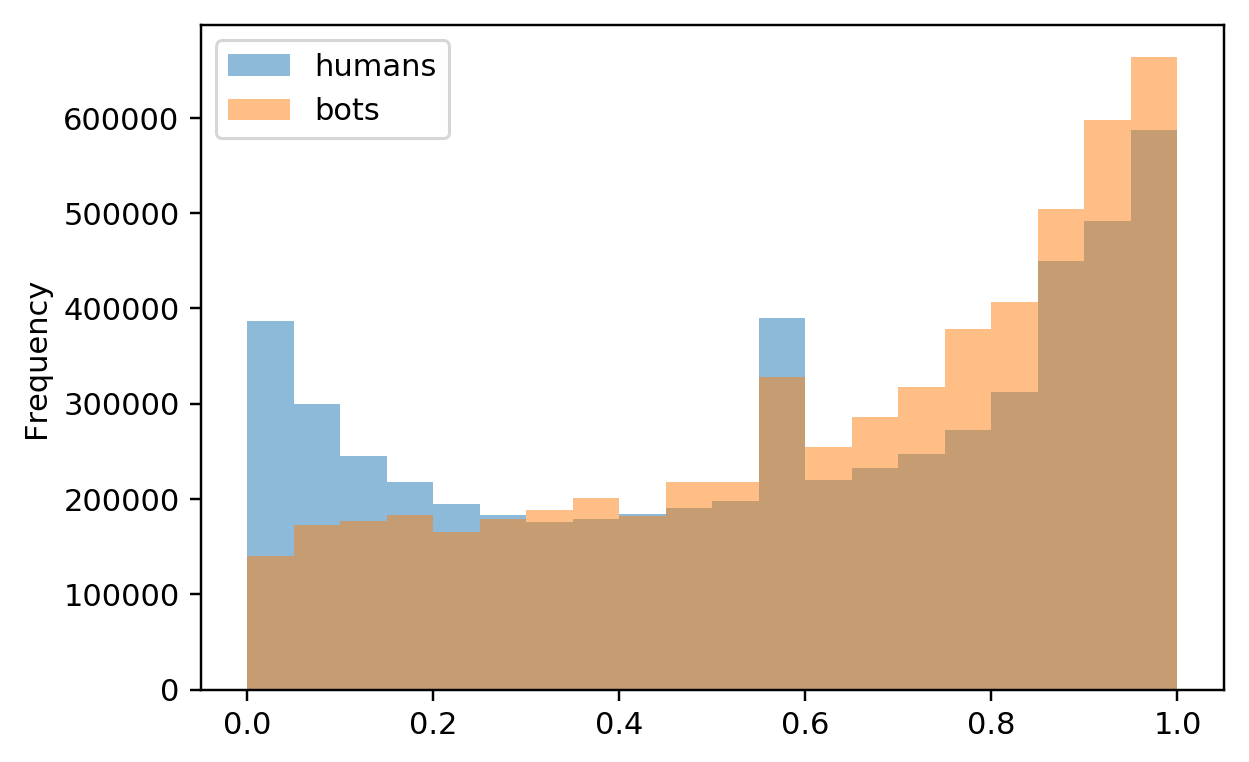

In [16]:
df_combined_sentiment.plot.hist(alpha=0.5, bins=20)

##### Normalized Histogram

Normalized probability distribution histogram.

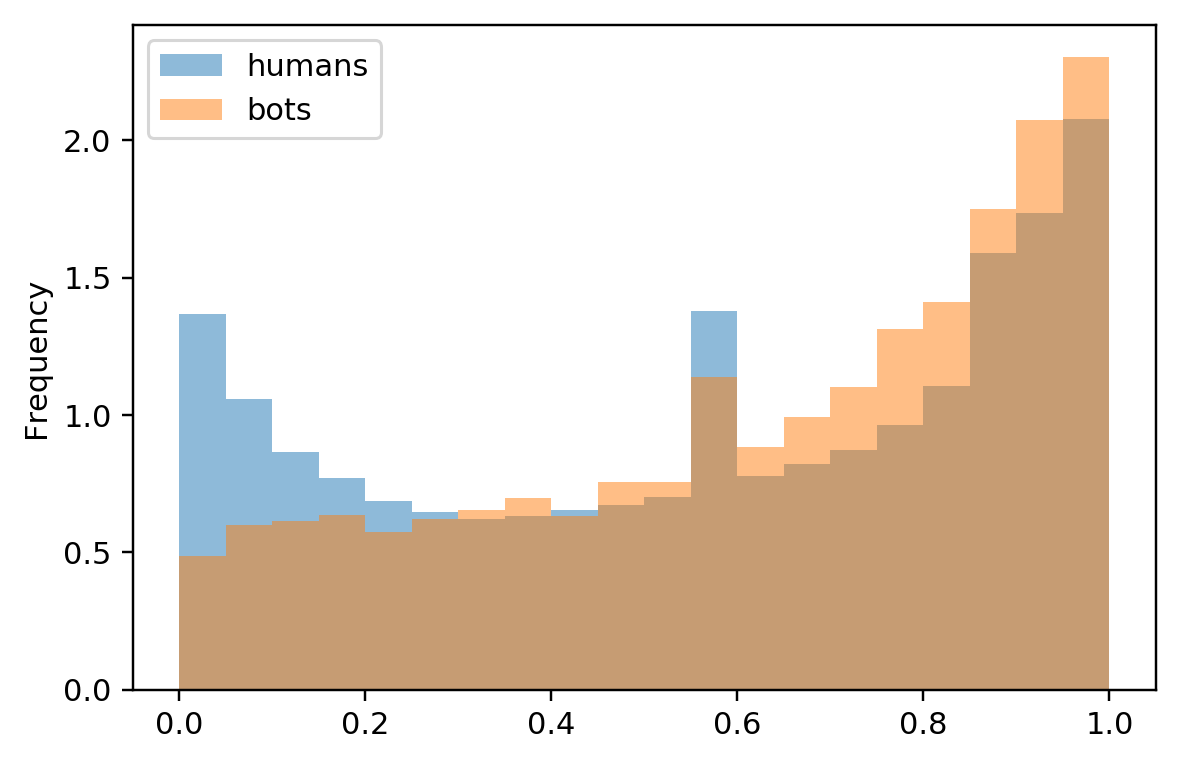

In [17]:
df_combined_sentiment.plot.hist(alpha=0.5, bins=20, density=True)

#### Plot positive and negative message count

Count the count of positive and negative messages for humans and bots.

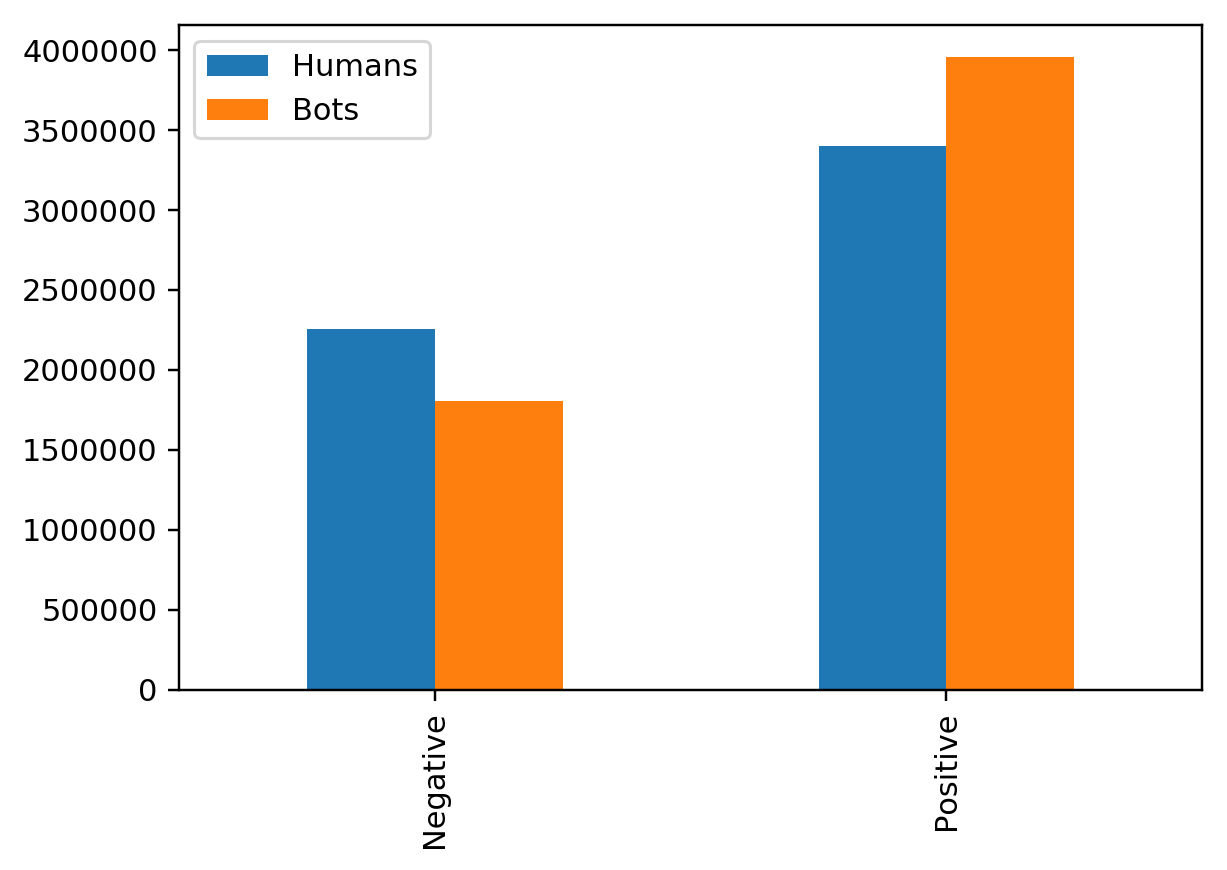

In [18]:
# there is probably a better way to do that with pandas but I can't figure it out right now
combined_humans_neg = len(df_combined_sentiment[df_combined_sentiment.humans < 0.5])
combined_humans_pos = len(df_combined_sentiment[df_combined_sentiment.humans > 0.5])
combined_bots_neg = len(df_combined_sentiment[df_combined_sentiment.bots < 0.5])
combined_bots_pos = len(df_combined_sentiment[df_combined_sentiment.bots > 0.5])

df_combined_count = pd.DataFrame({'Humans': {'Positive': combined_humans_pos, 'Negative': combined_humans_neg}, 
                   'Bots': {'Positive': combined_bots_pos, 'Negative': combined_bots_neg}})

df_combined_count.plot.bar()

#### Message counts, ratios and percentages

Number of total messages by humans and bots and number of positive and negative ones and their ratios.

In [19]:
combined_total_humans = len(df_combined_sentiment.humans.dropna())
combined_total_bots = len(df_combined_sentiment.bots.dropna())
print('Total by humans: ' + str(combined_total_humans))
print('Total by bots: ' + str(combined_total_bots))
print()
print('Total positive by humans: ' + str(combined_humans_pos))
print('Total negative by humans: ' + str(combined_humans_neg))
print('Percent positive by humans: ' + '{:.2%}'.format(combined_humans_pos / combined_total_humans))
print('Percent negative by humans: ' + '{:.2%}'.format(combined_humans_neg / combined_total_humans))
print('Positive ratio humans: ' + '{:.3}'.format(combined_humans_pos / combined_humans_neg))
print()
print('Total positive by bots: ' + str(combined_bots_pos))
print('Total negative by bots: ' + str(combined_bots_neg))
print('Percent positive by bots: ' + '{:.2%}'.format(combined_bots_pos / combined_total_bots))
print('Percent negative by bots: ' + '{:.2%}'.format(combined_bots_neg / combined_total_bots))
print('Positive ratio bots: ' + '{:.3}'.format(combined_bots_pos / combined_bots_neg))

Total by humans: 5657671
Total by bots: 5763796

Total positive by humans: 3400899
Total negative by humans: 2256772
Percent positive by humans: 60.11%
Percent negative by humans: 39.89%
Positive ratio humans: 1.51

Total positive by bots: 3955645
Total negative by bots: 1808151
Percent positive by bots: 68.63%
Percent negative by bots: 31.37%
Positive ratio bots: 2.19
